# SEAD - Aircraft Tutorial

Author: Pietro Campolucci

In [2]:
# import packages

import matplotlib.pyplot as plt
import math as m
%matplotlib notebook
from measurement.measures import Distance as d
from measurement.measures import Speed as s
from measurement.measures import Weight as w

## 0 - Input Values

In [3]:
# set input values 

# weight estimation values
MTOW = 59874
PL_max = 16670
FL_max = 17630
OEW = MTOW - PL_max - FL_max
w_pax = 81
n_pax = 120
cargo_tot = 3629
lug_weight = PL_max - cargo_tot - w_pax*n_pax

# cargo_values
h_cargo = 1.08
len_cargo_frw = 4.90
len_cargo_aft = 6.77
frw_cargo = 0.42
aft_cargo = 0.58
frw_cargo_weight = frw_cargo*cargo_tot
aft_cargo_weight = aft_cargo*cargo_tot
front_cargo_frw = 5.88
front_cargo_aft = 19.16
cg_cargo_frw = front_cargo_frw + 0.5*len_cargo_frw
cg_cargo_aft = front_cargo_aft + 0.5*len_cargo_aft

# wing geometrical data
wing_span = 35.1
sweep = 0.54 # radians
n_ult = 2.5
Cr = 7.12
Ct = 2.6
t_c = 0.15
S_h = 36.6
S_v = 28.2
lh = 41.65  #m
w_area = 112.3 # [m^2]

# fuselage data
w_f = 3.5 # width of fuselage [m]
h_f = 3.6 # height of fuselage [m]
len_fuselage = 34.1 # [m]
gross_area_fuselage = m.pi * (h_f/2)**2 * len_fuselage  # [m^2] 

# flight dynamics data
V_cruise = 871/3.6   # [m/s]
V_dive = 1.3 * V_cruise # [m/s]
takeoff_thrust = 94000 # [N]
engine_weight = 2177 # [kg] https://en.wikipedia.org/wiki/Pratt_%26_Whitney_PW1000G

# assumed values
lat_mac = 0.42

## 1 - Weight Estimation

<IPython.core.display.Javascript object>


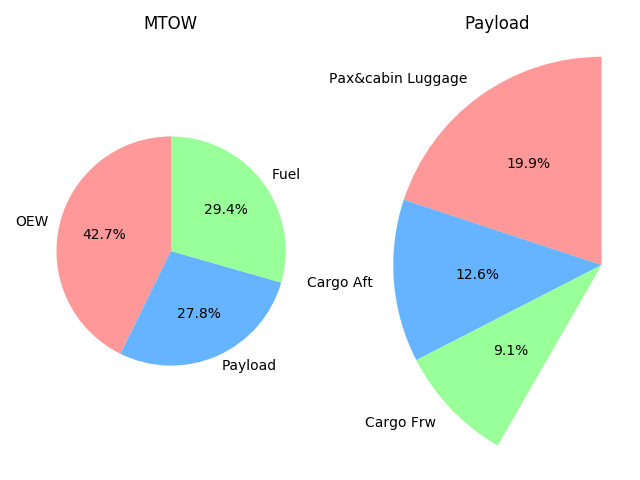

In [4]:
def plot_pie_chart():
    fig1, (ax1, ax2) = plt.subplots(1, 2)

    labels = ['OEW', 'Payload', 'Fuel']
    sizes = [OEW/MTOW, PL_max/MTOW, FL_max/MTOW]
    ax1.set_title("MTOW")
    # colors
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    patches1, texts1, autotexts1 = ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    plt.tight_layout()

    labels = ['Pax&cabin Luggage', 'Cargo Aft', 'Cargo Frw']
    sizes = [lug_weight/PL_max, aft_cargo_weight/PL_max, frw_cargo_weight/PL_max]
    ax2.set_title("Payload")
    # colors
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    patches2, texts2, autotexts2 = ax2.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax2.axis('equal')
    plt.tight_layout()

    plt.show()

plot_pie_chart()

## 2 - Get wing geometry 

In [6]:
cg = 0.25

def get_mac():
    # get mean aerodynamic chord values
    
    fuselage_diameter = 3.5
    c_tip = 2.6
    c_root = 7.12
    le_c_tip = 19.6
    le_c_root = 10.83
    sweep = (le_c_tip - le_c_root)/((wing_span - fuselage_diameter)/2)
    taper_ratio = c_tip/c_root
    length_mac = c_root * (2/3) * ((1 + taper_ratio + taper_ratio**2)/(1 + taper_ratio))
    le_mac = le_c_root + sweep*lat_mac*((wing_span - fuselage_diameter)/2)

    return round(length_mac, 3), round(le_mac, 3)


def get_mac_h_tail():

    h_span = 12.3
    fuselage_diameter = 1.7
    c_tip = 1.425
    c_root = 3.13
    le_c_tip = 34.1
    le_c_root = 29.2
    sweep = (le_c_tip - le_c_root)/((h_span - fuselage_diameter)/2)
    taper_ratio = c_tip/c_root
    length_mac = c_root * (2/3) * ((1 + taper_ratio + taper_ratio**2)/(1 + taper_ratio))
    le_mac = le_c_root + sweep*lat_mac*((h_span - fuselage_diameter)/2)

    return round(length_mac, 3), round(le_mac, 3)


def get_mac_v_tail():

    v_span = 6.6
    c_tip = 1.96
    c_root = 6.16
    le_c_tip = 34.1
    le_c_root = 25.93
    sweep = (le_c_tip - le_c_root) / v_span
    taper_ratio = c_tip / c_root
    length_mac = c_root * (2 / 3) * ((1 + taper_ratio + taper_ratio ** 2) / (1 + taper_ratio))
    le_mac = le_c_root + sweep * lat_mac * v_span

    return round(length_mac, 3), round(le_mac, 3)


def get_wing_geometry():

    # mac values
    mac, xlemac = get_mac()
    mac_h, xlemac_h = get_mac_h_tail()
    mac_v, xlemac_v = get_mac_v_tail()

    # wing geometry
    aerodynamic_center = 0.25  # percentage along the mac of the surface [ASSUMED]
    tail_arm = xlemac_h - xlemac
    surface_wing = 112.3
    surface_h = 36.6
    surface_v = 28.2

    ratio_hw = surface_h / surface_wing
    ratio_vw = surface_v / surface_wing

    v_h = (surface_h * (xlemac_h + aerodynamic_center*mac_h - xlemac - cg*mac)) / \
          (surface_wing * mac)  # VH = SH x LH / SW x m.a.c.
    v_v = (surface_v * (xlemac_v + aerodynamic_center*mac_v - xlemac - cg*mac)) / \
          (surface_wing * wing_span)  # VV = SV x LV / SW x b

    return mac, xlemac, tail_arm, surface_wing, surface_h, surface_v, ratio_hw, ratio_vw, v_h, v_v


def get_landing_gear_geometry():

    # wrt to nose
    front_lg = 3.5
    main_lg = 13.1
    mac, xlemac = get_mac()

    # get % wrt mac for main
    main_lg_mac = (main_lg - xlemac) / mac

    return front_lg, main_lg, main_lg_mac


print(f"mac and xlemac for wing: {get_mac()}")
print(f"mac and xlemac for horizontal tail: {get_mac_h_tail()}")
print(f"mac and xlemac for vertical tail: {get_mac_v_tail()}")
print()
print("Values for table")
print(f"tail arm: {round(get_wing_geometry()[2] ,3)}")
print(f"surfaces (wing, horizontal, vertical): {get_wing_geometry()[3:6]}")
print(f"ratio (HW and VW): {get_wing_geometry()[6:8]}")
print(f"horizontal and vertical tail volume coefficients: {get_wing_geometry()[8:10]}")

mac and xlemac for wing: (5.21, 14.513)
mac and xlemac for horizontal tail: (2.384, 31.258)
mac and xlemac for vertical tail: (4.422, 29.361)

Values for table
tail arm: 16.745
surfaces (wing, horizontal, vertical): (112.3, 36.6, 28.2)
ratio (HW and VW): (0.3259127337488869, 0.25111308993766696)
horizontal and vertical tail volume coefficients: (1.003292011560753, 0.10481646383694468)


## 3 - Get CG Position

The cg position is based on the Torenbek Method, as it is suitable for aircrafts with empty weight higher than 25000 lbs

In [62]:
# make conversion units

def lbs(kg):
    return 2.2046244202 * kg

def ft(m):
    return 3.280839895 * m

def ft2(m2):
    return 10.763910417 * m2

def knt(ms):
    return 1.94 * ms

def pt(N):
    return 1/4.445 * N

In [63]:
def get_weights():
    # Using Torenbeek Method
    
    MZF = lbs(MTOW) - lbs(FL_max)
    
    wing = 0.0017 * MZF * (ft(wing_span)/m.cos(sweep))**(0.75) \
           * (1 +((6.3*m.cos(sweep) / ft(wing_span))**0.5) * (n_ult**0.55) \
           * ((ft(wing_span)*ft2(w_area))/((t_c*Cr)*MZF*m.cos(sweep)))**0.30)
                          
    empennage = 0.04 * (n_ult * (ft2(S_v + S_h))**2)**0.75
    
    fuselage = 0.021 * 1.08 * ((knt(V_dive)*ft(lh)) / (ft(w_f)+ft(h_f)))**(0.5) \
               * (ft2(gross_area_fuselage))**(1.2)
    
    engines = lbs(engine_weight) * 2 + 0.060 * pt(takeoff_thrust) # plus nacelle
    
    landing_gear_nose = 20 + 0.1*lbs(MTOW)**(3/4) + 2e-6*(lbs(MTOW))**(3/2)
    
    landing_gear_main = 40 + 0.16*lbs(MTOW)**(3/4) + 0.019*lbs(MTOW) + 2e-6*(lbs(MTOW))**(3/2)
    
    return wing, empennage, fuselage, engines, landing_gear_nose, landing_gear_main

def get_cogs():
    # Getting centers of gravity for every part of aircraft estimated before, based on drawings
    
    wing = 14.7
    
    empennage = 31.85
    
    fuselage = len_fuselage / 2

    engines = 12.25
    
    landing_gear_nose = 4.41
    
    landing_gear_main = 16.66
    
    return wing, empennage, fuselage, engines, landing_gear_nose, landing_gear_main

def get_cg():
    
    len_mac, le_mac = get_mac()
    
    weights = get_weights()
    
    cogs = get_cogs()
    
    sum_weights = lbs(sum(weights))
    
    moment_tot = 0
    
    for i in range(len(weights)):
        moment_tot += lbs(weights[i])*cogs[i]
        
    cg_abs = moment_tot / sum_weights
    
    cg_mac = (cg_abs - le_mac) / len_mac
    
    return cg_abs, cg_mac
    
print(f"weights in lbs: {get_weights()}\n")

print(f"COG absolute: {get_cg()[0]}")
print(f"COG % lemac: {get_cg()[1]}")

cg = get_cg()[1]

weights in lbs: (8838.081034340483, 1464.9831132957413, 26269.6901818125, 10867.776120376446, 808.4313830661023, 3751.9348107543315)

COG absolute: 15.839734465135027
COG % lemac: 0.25465152881670394


## 4 - Get Loading Diagram

In [64]:
# Define functions for loading

def convert(cg_wrt_mac):
    # covert relative cg to absolute
    
    len_mac, le_mac = get_mac()
    return le_mac + cg_wrt_mac*len_mac


def cg_shift(w_start, w_add1, w_add2, cg_start, cg_add1, cg_add2):

    # get cg along the aircraft
    cg_new = (w_start*cg_start + w_add1*cg_add1 + w_add2*cg_add2)/(w_start + w_add1 + w_add2)

    # resize wrt to mac
    len_mac, le_mac = get_mac()
    cg_new = (cg_new - le_mac)/len_mac
    weight_new = w_start + w_add1 + w_add2

    return cg_new, weight_new


def cg_shift_pax(start_weight, start_cg, x2=False, front_back=False):

    # add passengers window
    len_mac, le_mac = get_mac()
    lines = 5
    rows = int(n_pax/lines)
    front_seats = 10.773
    back_seats = 28.557
    spacing = (back_seats - front_seats)/rows

    if x2:
        w_add = 2*n_pax
    else:
        w_add = n_pax

    cg_list = []
    w_list = []

    if front_back:
        current_seat = front_seats
    else:
        current_seat = back_seats

    current_weight = start_weight
    current_cg = le_mac + start_cg*len_mac

    for pax in range(rows):
        added_pax = cg_shift(current_weight, w_add, 0, current_cg, current_seat, 0)
        cg_list.append(added_pax[0])
        w_list.append(added_pax[1])

        # update status
        if front_back:
            current_seat += spacing
        else:
            current_seat -= spacing

        current_weight = added_pax[1]
        current_cg = le_mac + added_pax[0] * len_mac

    return cg_list, w_list

<IPython.core.display.Javascript object>


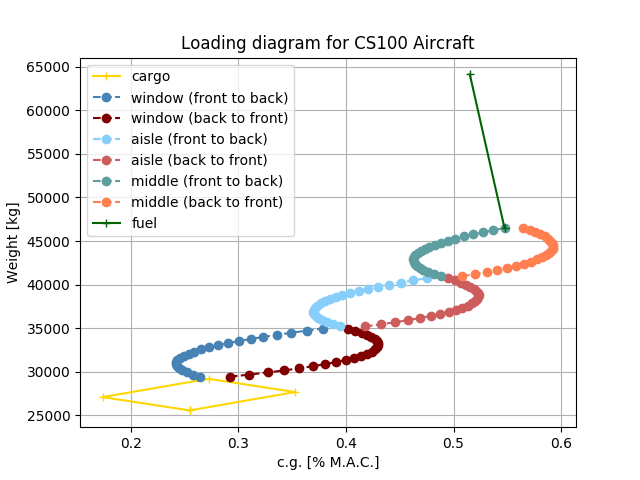

In [65]:
# plot the diagram

def loading_diagram():

    # initialize
    len_mac, le_mac = get_mac()
    len_cg = le_mac + cg*len_mac

    # add cargo forward
    added_cargo_frw = cg_shift(OEW, frw_cargo_weight, 0, len_cg, cg_cargo_frw, 0)
    added_cargo_aft = cg_shift(OEW, aft_cargo_weight, 0, len_cg, cg_cargo_aft, 0)
    added_cargo_all = cg_shift(OEW, frw_cargo_weight, aft_cargo_weight, len_cg, cg_cargo_frw, cg_cargo_aft)

    cargo_x = [cg, added_cargo_aft[0], added_cargo_all[0], added_cargo_frw[0], cg]
    cargo_y = [OEW, added_cargo_aft[1], added_cargo_all[1], added_cargo_frw[1],  OEW]

    # adding window seats
    cg_list_window_front_back, w_list_window_front_back = \
        cg_shift_pax(added_cargo_all[1], added_cargo_all[0], True, True)
    cg_list_window_back_front, w_list_window_back_front = \
        cg_shift_pax(added_cargo_all[1], added_cargo_all[0], True, False)

    # adding aisle seats
    cg_list_aisle_front_back, w_list_aisle_front_back = \
        cg_shift_pax(w_list_window_back_front[-1], cg_list_window_back_front[-1], True, True)
    cg_list_aisle_back_front, w_list_aisle_back_front = \
        cg_shift_pax(w_list_window_back_front[-1], cg_list_window_back_front[-1], True, False)

    # adding middle seats
    cg_list_middle_front_back, w_list_middle_front_back = \
        cg_shift_pax(w_list_aisle_back_front[-1], cg_list_aisle_back_front[-1], True, True)
    cg_list_middle_back_front, w_list_middle_back_front = \
        cg_shift_pax(w_list_aisle_back_front[-1], cg_list_aisle_back_front[-1], True, False)

    # add fuel contribution
    cg_fuel = 0.43  # ASSUMED
    cg_end_pax, w_end_pax = cg_list_middle_front_back[-1], w_list_middle_front_back[-1]
    cg_end, w_end = cg_shift(w_end_pax, FL_max, 0, convert(cg_end_pax), convert(cg_fuel), 0)

    fuel_list_cg = [cg_end_pax, cg_end]
    fuel_list_w = [w_end_pax, w_end]

    plt.figure()

    plt.title("Loading diagram for CS100 Aircraft")
    plt.plot(cargo_x, cargo_y, "+-", color="gold", label="cargo")
    plt.plot(cg_list_window_front_back, w_list_window_front_back, "o--", color="steelblue", label="window (front to back)")
    plt.plot(cg_list_window_back_front, w_list_window_back_front, "o--", color="maroon", label="window (back to front)")
    plt.plot(cg_list_aisle_front_back, w_list_aisle_front_back, "o--", color="lightskyblue", label="aisle (front to back)")
    plt.plot(cg_list_aisle_back_front, w_list_aisle_back_front, "o--", color="indianred", label="aisle (back to front)")
    plt.plot(cg_list_middle_front_back, w_list_middle_front_back, "o--", color="cadetblue", label="middle (front to back)")
    plt.plot(cg_list_middle_back_front, w_list_middle_back_front, "o--", color="coral", label="middle (back to front)")
    plt.plot(fuel_list_cg, fuel_list_w, "+-", color="darkgreen", label="fuel")
    plt.xlabel("c.g. [% M.A.C.]")
    plt.ylabel("Weight [kg]")
    plt.legend()
    plt.grid()

    plt.show()
    
loading_diagram()

## 5 - Landing Gear Information

In [67]:
def get_landing_gear_geometry():

    # wrt to nose
    front_lg = 3.5
    main_lg = 16.66
    mac, xlemac = get_mac()

    # get % wrt mac for main
    main_lg_mac = (main_lg - xlemac) / mac

    return front_lg, main_lg, main_lg_mac

print(f"Front and main wrt to nose: {get_landing_gear_geometry()[:2]}")
print(f"Main lg wrt MAC: {get_landing_gear_geometry()[-1]}")

Front and main wrt to nose: (3.5, 16.66)
Main lg wrt MAC: 0.41209213051823423


## 6 - Stability and control information

In [11]:
def get_coefficients():

    cruise_M = 0.78
    cruise_h = 8800
    landing_speed = 200 / 3.6 # estimated
    cruise_speed = 829 / 3.6

    rho_cruise = 0.5258 + (0.4671 - 0.5258)*0.8
    rho_landing = 1.225 # https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html

    Cl0 = (2*(MTOW - FL_max*0.1)*9.81)/(rho_cruise*cruise_speed**2*112.3)
    Cl_max = (2*(MTOW - FL_max*0.9)*9.81)/(rho_landing*landing_speed**2*112.3)
    
    return Cl0, Cl_max

print(f"Lift coefficient at cruise and landing: {get_coefficients()}")

Lift coefficient at cruise and landing: (0.39983712324309406, 2.0335269461173606)
